# Focality Branch
- find a way of simulating focal vs non-focal tasks

In [1]:
from glob import glob as glob
import torch as tr
import numpy as np

from PMmodel import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# train and eval script

In [23]:
## task
nback=2
ntokens_og=3
num_pm_trials=3
edim_og=5
edim_pm=5
focal=1
pm_weight = 1
trseqlen = 25

## network
indim = edim_og+edim_pm
stsize = 20
batch=1
outdim=3
arch = 'wmem'

In [24]:
# model and task
if arch=='purewm': net = Net(indim,stsize,outdim)
elif arch=='wmem': net = Net_wmem(indim,stsize,outdim)
task = NBackPMTask(nback,ntokens_og,num_pm_trials,edim_og,edim_pm,focal,seed=132)

# specify loss and optimizer
lossop = tr.nn.CrossEntropyLoss(weight=tr.Tensor([1,1,pm_weight]))
optiop = tr.optim.Adam(net.parameters(), lr=0.005)

focal


### train

In [13]:
thresh = .99
nepochs = 1
L = -np.ones([nepochs])
A = -np.ones([nepochs])
E = -np.ones([nepochs])

acc = 0
nembeds = 0
for ep in range(nepochs):
  if ep%(nepochs/5)==0:
    print(ep/nepochs)
  # randomize emat
  if acc>thresh:
    task.sample_emat()
    nembeds+=1
  # generate data
  x_seq,y_seq = task.gen_seq(trseqlen)
  x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
  # forward prop
  yhat = net(x_embeds)
  # collect loss through time
  loss,acc = 0,0
  for yh,yt in zip(yhat,ytarget):
    loss += lossop(yh,yt)
    acc += yt==tr.argmax(tr.softmax(yh,1))
  acc = acc.numpy()/len(yhat)
  # bp and update
  optiop.zero_grad()
  loss.backward()
  optiop.step()
  epoch_loss = loss.item()
  L[ep] = epoch_loss
  A[ep] = acc
  E[ep] = nembeds

0.0


### eval

In [14]:
def eval_(net,task):
  teseqlen = 15
  neps = 1500
  score = -np.ones([neps,teseqlen])
  for ep in range(neps):
    # embedding matrix
    task.sample_emat()
    # generate data
    x_seq,y_seq = task.gen_seq(teseqlen,pm_trial_position=[5,9])
    x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
    # forward prop
    yhat = net(x_embeds)
    ep_score = (ytarget == tr.softmax(yhat,-1).argmax(-1)).float().squeeze()
    score[ep] = ep_score 
  return score

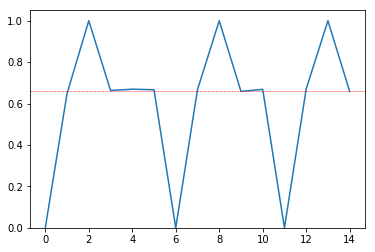

In [15]:
score = eval_(net,task)
plt.plot(score.mean(0))
plt.ylim(0,1.05)
plt.axhline(.66,c='r',lw=.5,ls='--')